In [1]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy 

In [2]:
X, y, le = read_data(dataset)

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for X_train

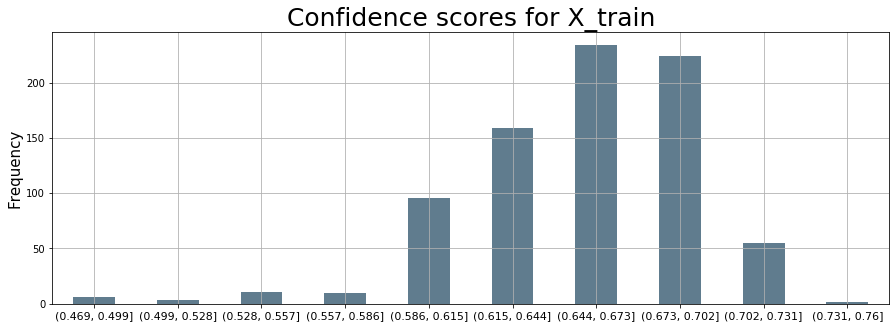

In [4]:
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Train CTGAN and plot the training loss

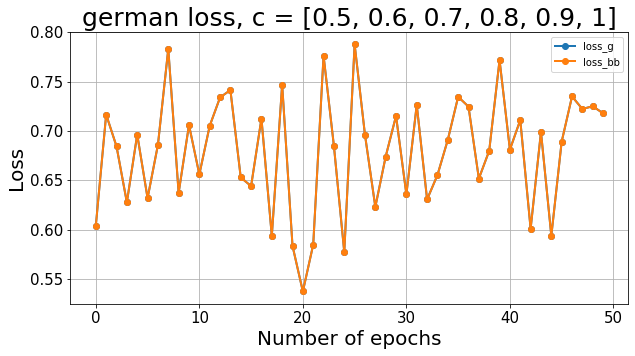

In [5]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
confidence_level = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
gen_lr = 2e-5
loss = 'log'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    verbose=False
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

# D. Plot confidence scores for 100 generated samples 

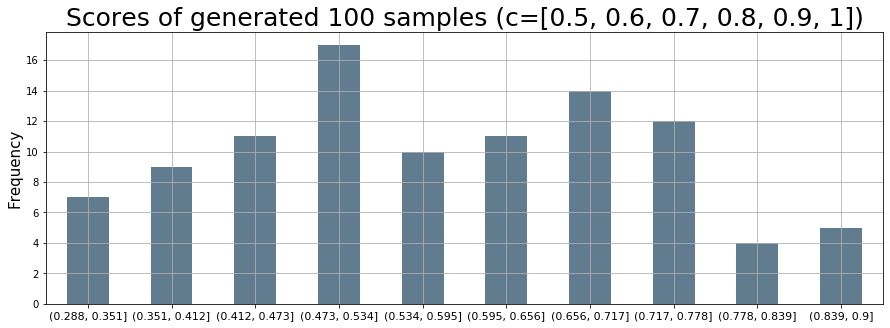

In [6]:
# check confidence for the generated samples
samples = 100

gen_data = rf_ctgan.sample(samples)
y_prob = rf.predict_proba(gen_data)
y_conf_gen = y_prob[:, 0]  # confidence scores

plot_confidence_levels(y_conf_gen, f"Scores of generated {samples} samples (c={confidence_level})")

# Evaluation:
For each level of confidence in {0.5, 0.6, 0.7, 0.8, 0.9, 1}:
1. Extract 100 samples
2. X1 ← Select the 5 samples with highest BB-model scores
3. Calculate_samples_similarity_Stats(X1)
4. X2 ← Select the 5 samples with BB-model scores closest to the desired level of confidence
5. Calculate_samples_similarity_Stats(X2)




==> confidence_level = 0.5
indecies:
	[1 3 5 6 7]
confidence levels:
	[0.66 0.6  0.66 0.76 0.62]
gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
	{1: (268, 0.825), 3: (472, 0.998), 5: (426, 0.957), 6: (421, 0.623), 7: (108, 0.992)}
confidence scores for similar samples:
	[0.68 0.63 0.63 0.61 0.67]


,gen_idx,score,sim_idx,score,similarity
0,1,0.66,268,0.68,0.825
1,3,0.60,472,0.63,0.998
2,5,0.66,426,0.63,0.957
3,6,0.76,421,0.61,0.623
4,7,0.62,108,0.67,0.992


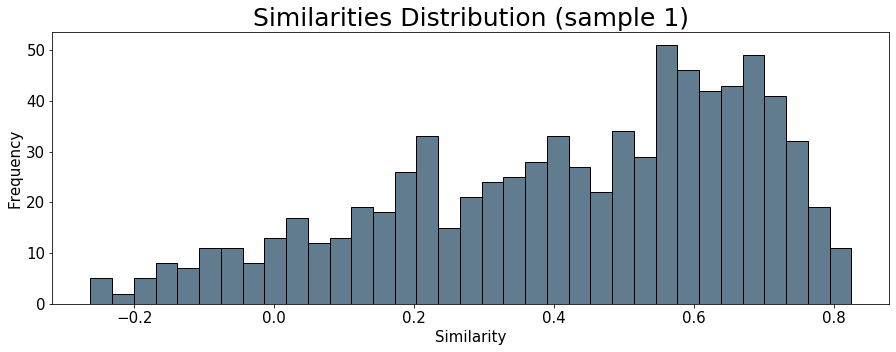

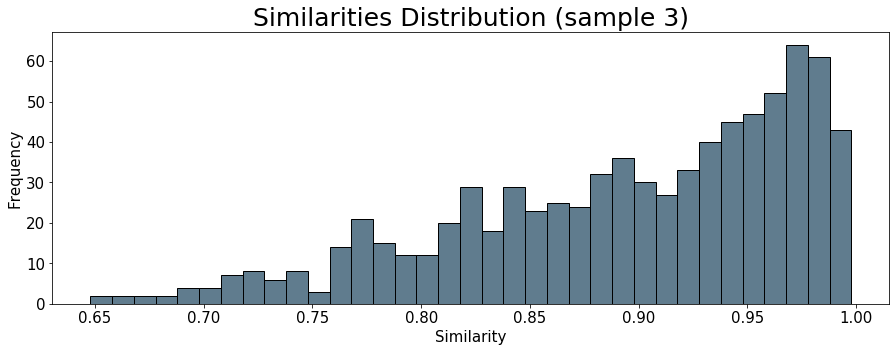

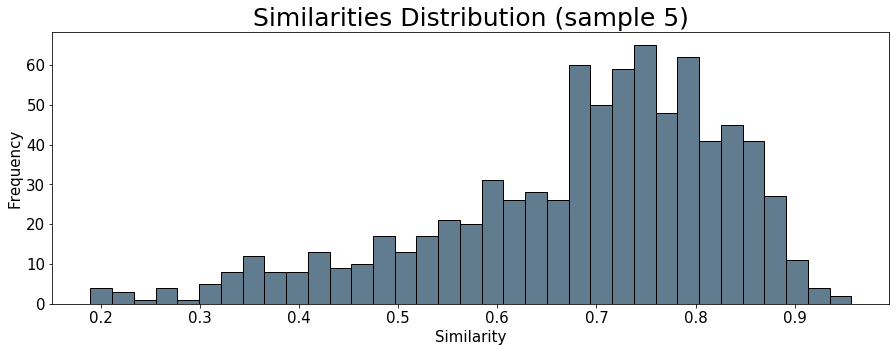

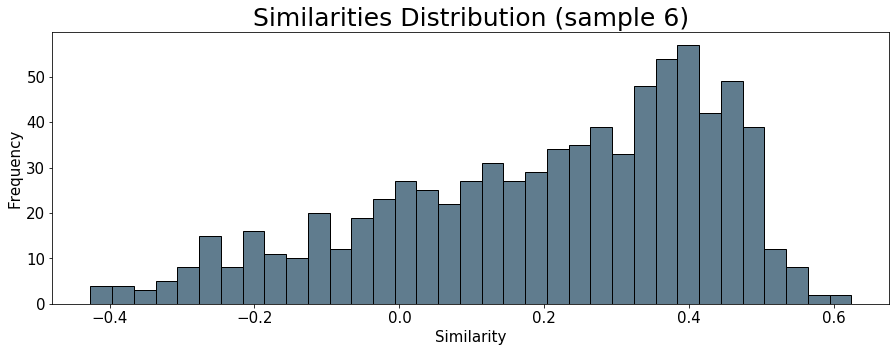

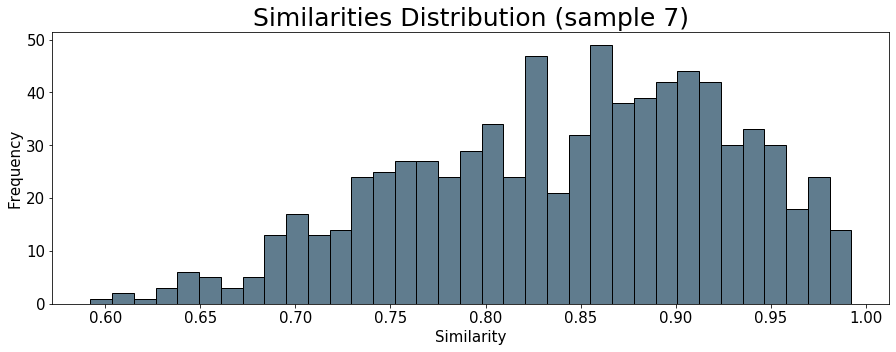



==> confidence_level = 0.6
indecies:
	[ 1  5  6  7 11]
confidence levels:
	[0.66 0.66 0.76 0.62 0.77]
gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
	{1: (268, 0.825), 5: (426, 0.957), 6: (421, 0.623), 7: (108, 0.992), 11: (421, 0.801)}
confidence scores for similar samples:
	[0.68 0.63 0.61 0.67 0.61]


,gen_idx,score,sim_idx,score,similarity
0,1,0.66,268,0.68,0.825
1,5,0.66,426,0.63,0.957
2,6,0.76,421,0.61,0.623
3,7,0.62,108,0.67,0.992
4,11,0.77,421,0.61,0.801


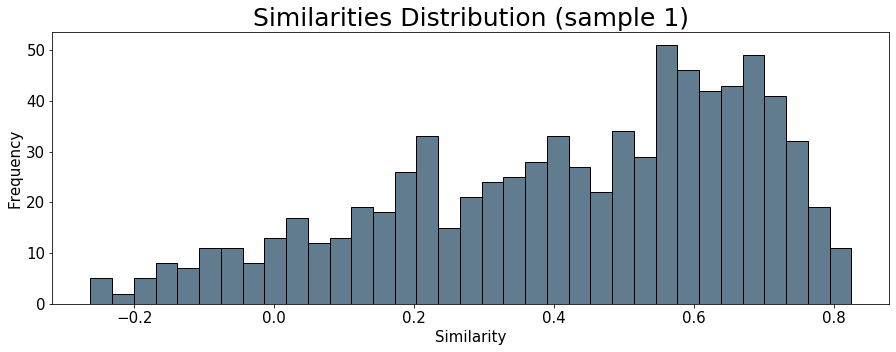

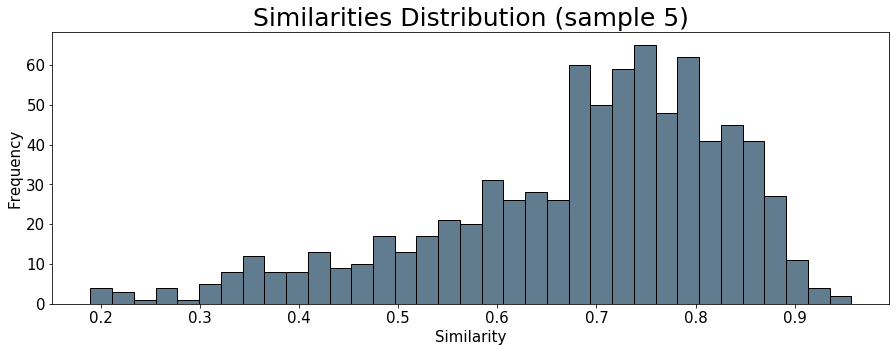

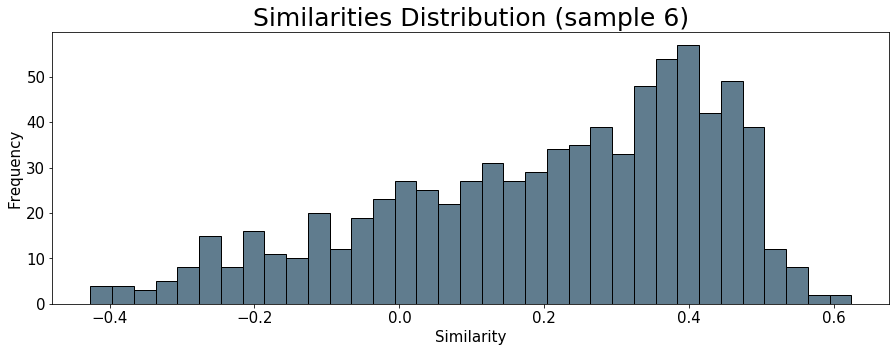

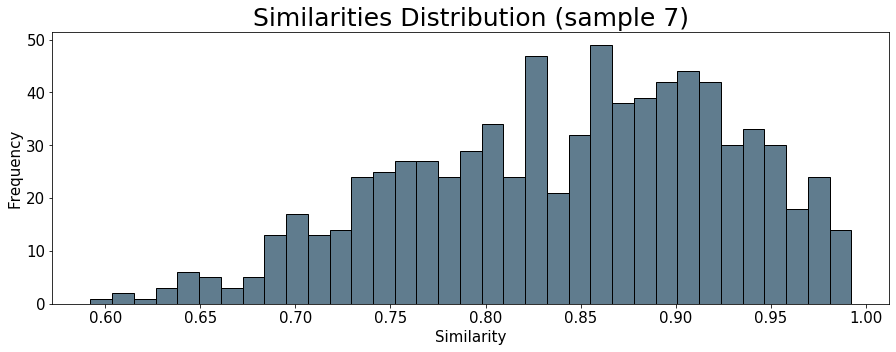

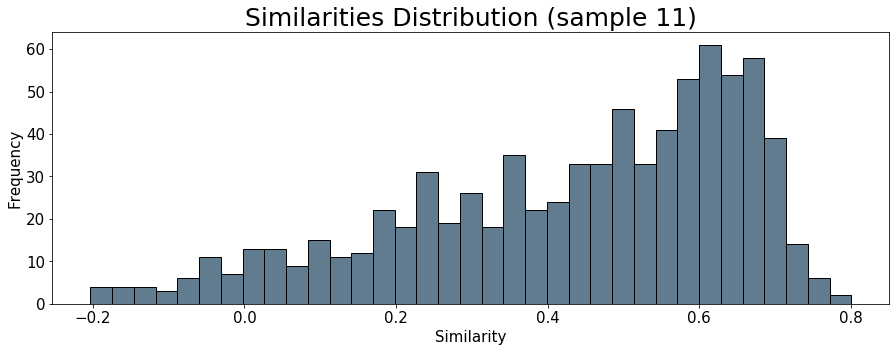



==> confidence_level = 0.7
indecies:
	[ 6 11 13 15 19]
confidence levels:
	[0.76 0.77 0.74 0.73 0.75]
gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
	{6: (421, 0.623), 11: (421, 0.801), 13: (479, 0.998), 15: (268, 0.621), 19: (301, 0.961)}
confidence scores for similar samples:
	[0.61 0.61 0.65 0.68 0.68]


,gen_idx,score,sim_idx,score,similarity
0,6,0.76,421,0.61,0.623
1,11,0.77,421,0.61,0.801
2,13,0.74,479,0.65,0.998
3,15,0.73,268,0.68,0.621
4,19,0.75,301,0.68,0.961


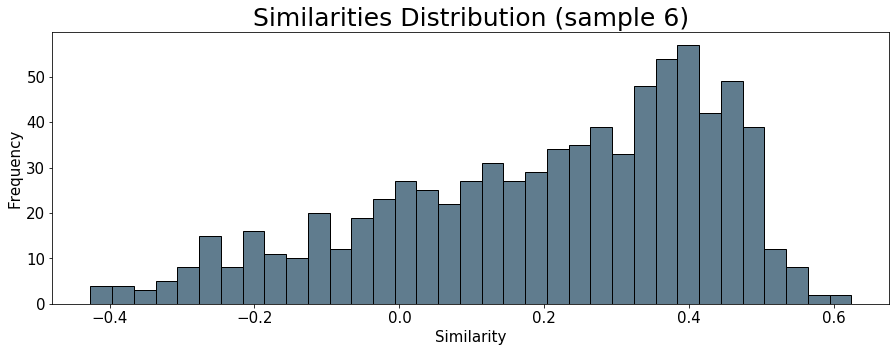

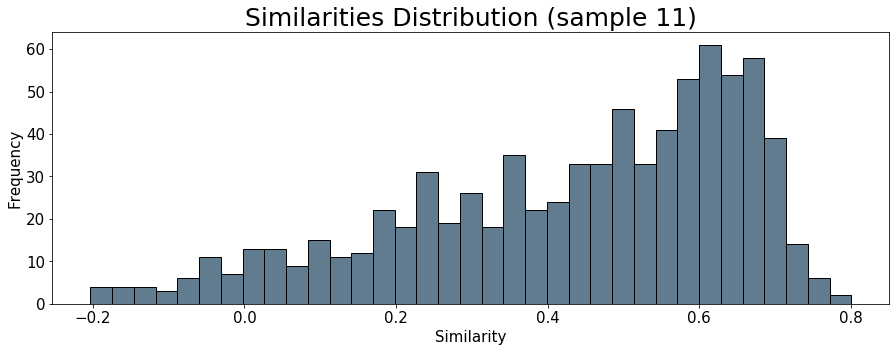

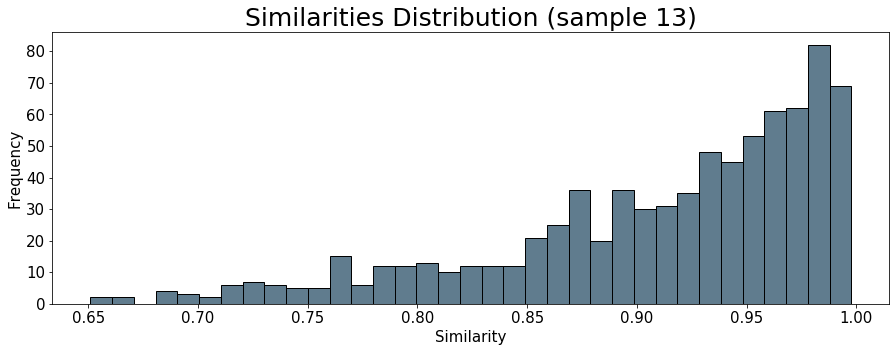

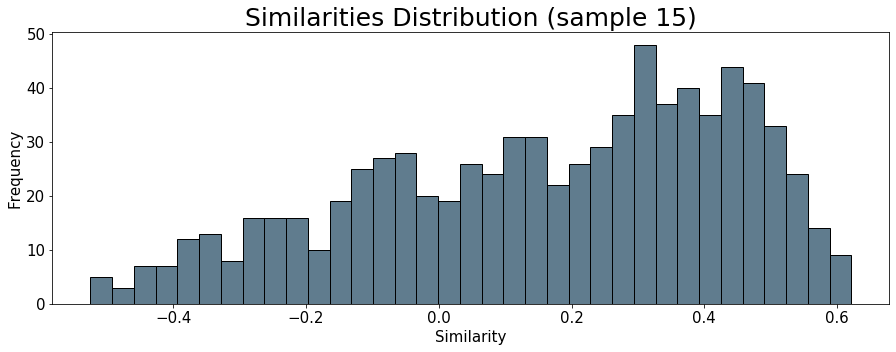

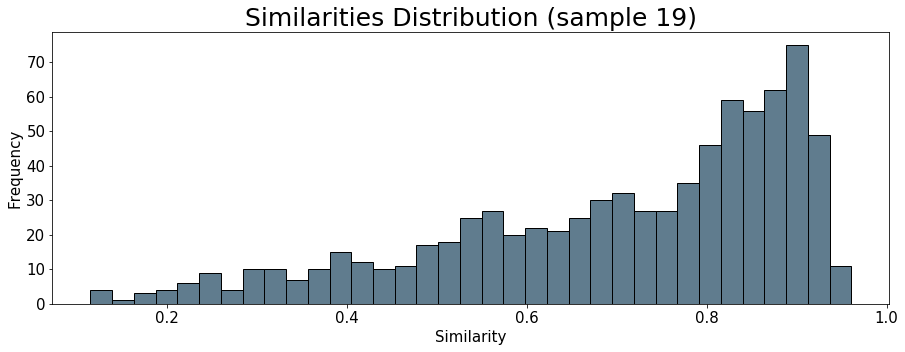



==> confidence_level = 0.8
indecies:
	[25 44 66 78 85]
confidence levels:
	[0.85 0.86 0.88 0.9  0.87]
gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
	{25: (239, 0.996), 44: (268, 0.934), 66: (94, 0.996), 78: (522, 0.996), 85: (287, 0.997)}
confidence scores for similar samples:
	[0.68 0.68 0.67 0.63 0.63]


,gen_idx,score,sim_idx,score,similarity
0,25,0.85,239,0.68,0.996
1,44,0.86,268,0.68,0.934
2,66,0.88,94,0.67,0.996
3,78,0.90,522,0.63,0.996
4,85,0.87,287,0.63,0.997


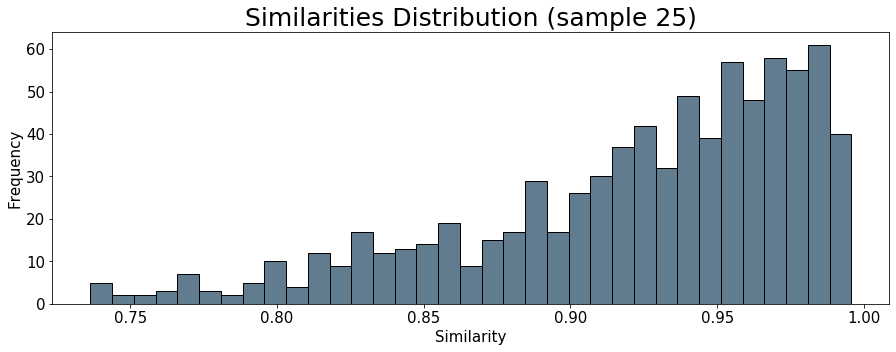

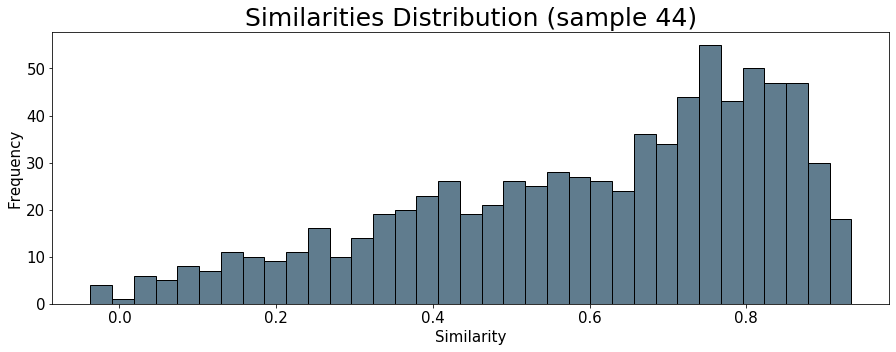

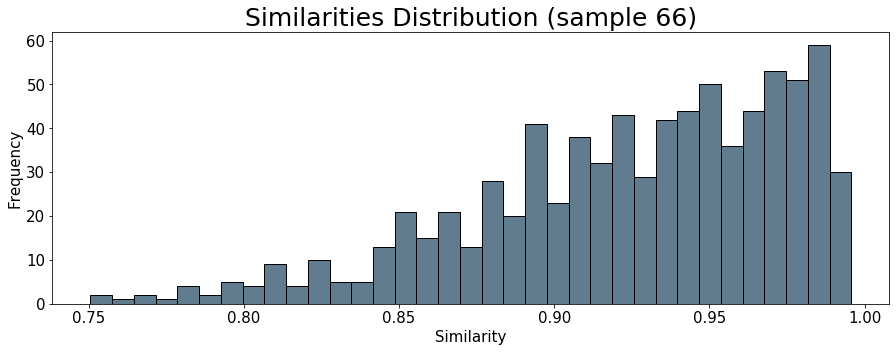

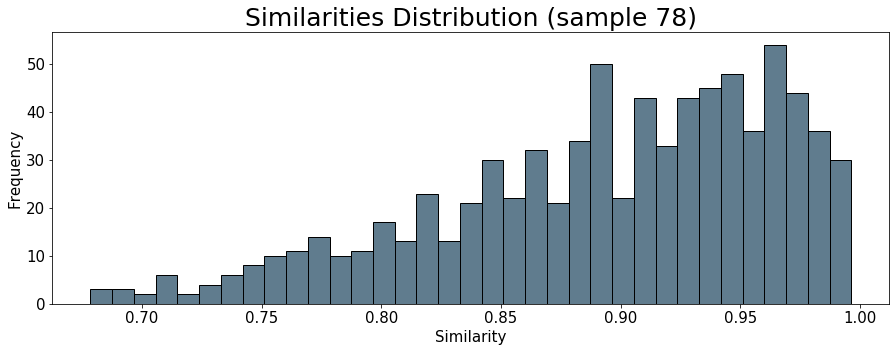

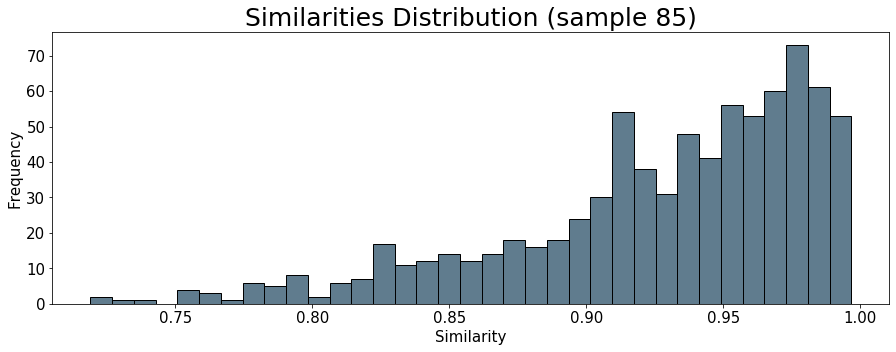



==> confidence_level = 0.9
indecies:
	[]
confidence levels:
	[]
gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
	{}
confidence scores for similar samples:
	[]


,gen_idx,score,sim_idx,score,similarity


==> confidence_level = 1
indecies:
	[]
confidence levels:
	[]
gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
	{}
confidence scores for similar samples:
	[]


,gen_idx,score,sim_idx,score,similarity


In [14]:
take_top = 5
for c in confidence_level:
    # find samples s such that s.confidence > c
    indices = np.argwhere(y_conf_gen>c).squeeze()[:take_top]
    print(f"==> confidence_level = {c}" )
    print(f"indecies:\n\t{indices}\nconfidence levels:\n\t{y_conf_gen[indices]}")
    gen_indices = indices if indices.shape != () else [indices] # avoide no shape arrays

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_above_c_before = gen_data.iloc[gen_indices]
    gen_data_above_c = scaler.inverse_transform(gen_data_above_c_before)
    gen_data_above_c = pd.DataFrame(gen_data_above_c).set_index(gen_data_above_c_before.index)

# F. Print most similar examples (X_similiar)

    similarities = calc_similarities(gen_data_above_c, X_train)
    X_similiar_indices = [el[0] for el in similarities.values()]
    print(f"gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)\n\t{similarities}")

# G. Print confidence scores for X_similiar

    # extract X_similiar 
    X_train_pd = pd.DataFrame(X_train)
    X_similiar = X_train_pd.iloc[X_similiar_indices]

    # print confidence scores
    # y_prob_similar = rf.predict_proba(X_similiar)
    # y_conf_similar = y_prob_similar[:, 0]
    print(f"confidence scores for similar samples:\n\t{y_conf_train[X_similiar_indices]}")


# Plot as table

    data = []
    for gen_idx, value in similarities.items():
        similar_idx = value[0]
        similarity = value[1]
        gen_conf = y_conf_gen[gen_idx]
        similar_conf = y_conf_train[similar_idx]
        data.append([gen_idx, gen_conf, similar_idx, similar_conf, similarity])

    columns = ['gen_idx', 'score', 'sim_idx', 'score', 'similarity']
    results = pd.DataFrame(data, columns=columns) 
    display(results)

# Plot Similarities Distribution 

    plot_similarities_dist(gen_data_above_c, X_train)